In [1]:
import librosa
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [2]:
DATA_DIR = "../data"
AR_DIR = DATA_DIR + "/AR"
ES_DIR = DATA_DIR + "/ES"
FR_DIR = DATA_DIR + "/FR"
TR_DIR = DATA_DIR + "/TR"

In [3]:
filename_ar = "/0a0d1abd-0bd3-45f8-818f-8ab214be329e.flac"
filename_es = "/0a530b75-d3b1-4533-8ca9-f405d41b445e.flac"
filename_fr = "/00c2529e-9705-464e-bbc2-acbe19916095.flac"
filename_tr = "/00a38ecc-2a37-4c3f-803b-607031004e4f.flac"

file_path_ar = AR_DIR + filename_ar
file_path_es = ES_DIR + filename_es
file_path_fr = FR_DIR + filename_fr
file_path_tr = TR_DIR + filename_tr

In [4]:
y_ar, sr_ar = librosa.load(file_path_ar, sr=None)
y_es, sr_es = librosa.load(file_path_es, sr=None)
y_fr, sr_fr = librosa.load(file_path_fr, sr=None)
y_tr, sr_tr = librosa.load(file_path_tr, sr=None)

In [5]:
HOP_LENGTH = 512
NFFT = 2048

# Sample Spectrograms

In [6]:
def spec_show(y, sr, title):
    mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr, hop_length=HOP_LENGTH, n_fft=NFFT)

    # Spektrogramı Görselleştir
    plt.figure(figsize=(10, 4))

    db_spec = librosa.power_to_db(mel_spectrogram, ref=np.max)
    
    print(db_spec.shape)
    librosa.display.specshow(db_spec, sr=sr, x_axis='time', y_axis='mel')


    plt.colorbar(format='%+2.0f dB')
    plt.title(f'Mel-Spektrogram - {title}')
    plt.tight_layout()
    plt.show()

AR
(128, 466)


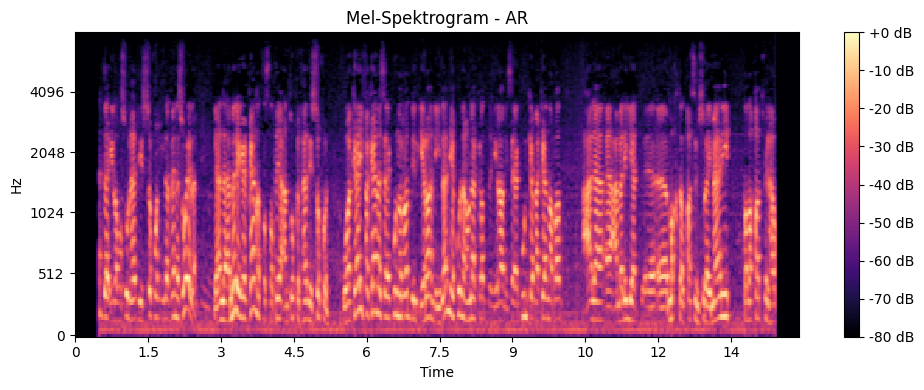

(128, 451)


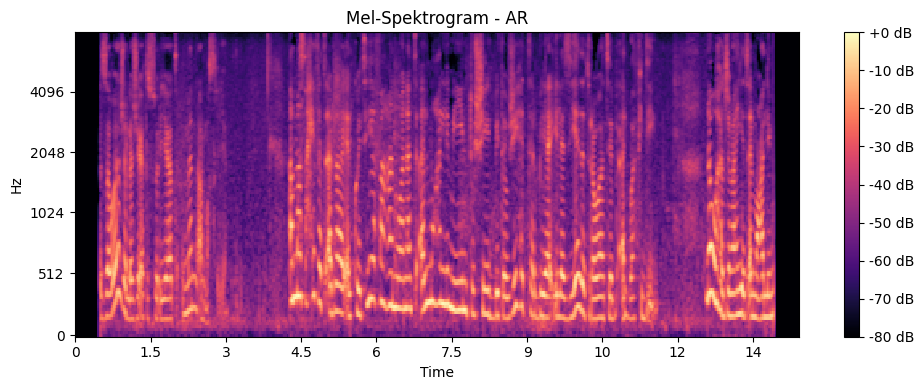

(128, 419)


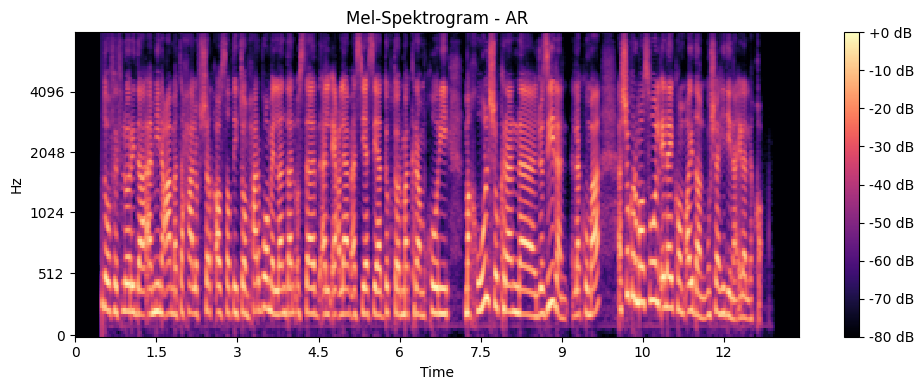

ES
(128, 466)


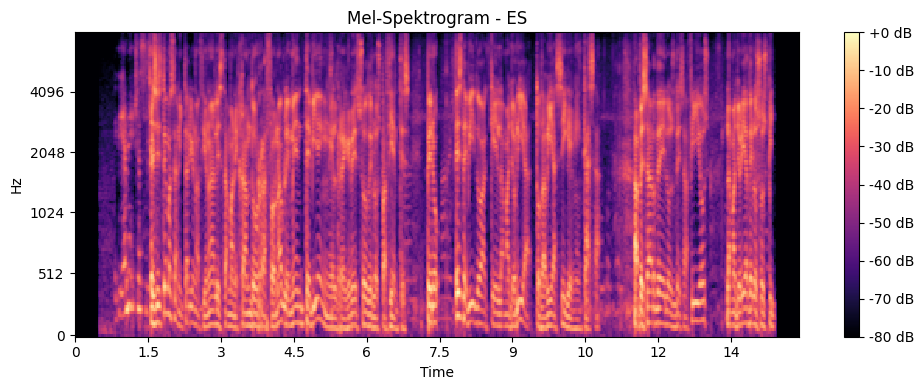

(128, 460)


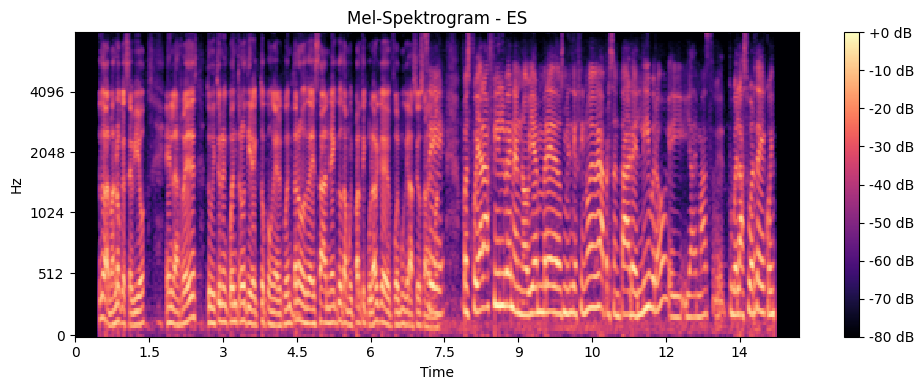

(128, 229)


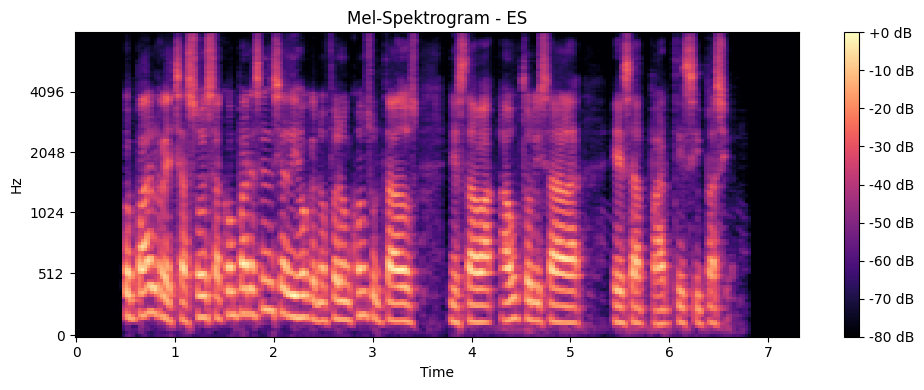

FR
(128, 463)


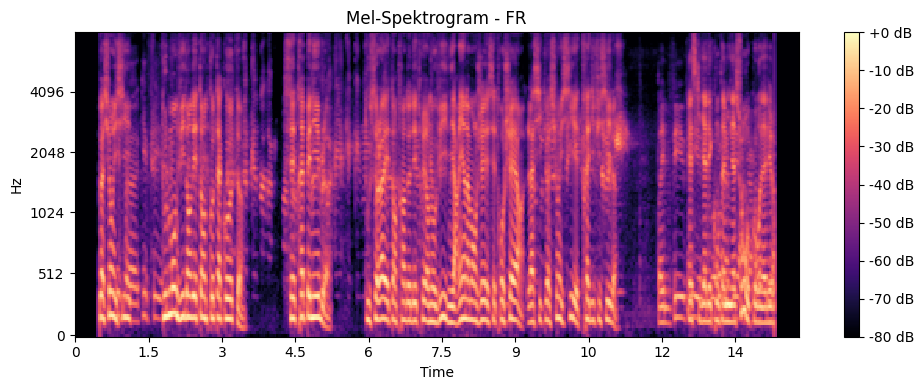

(128, 413)


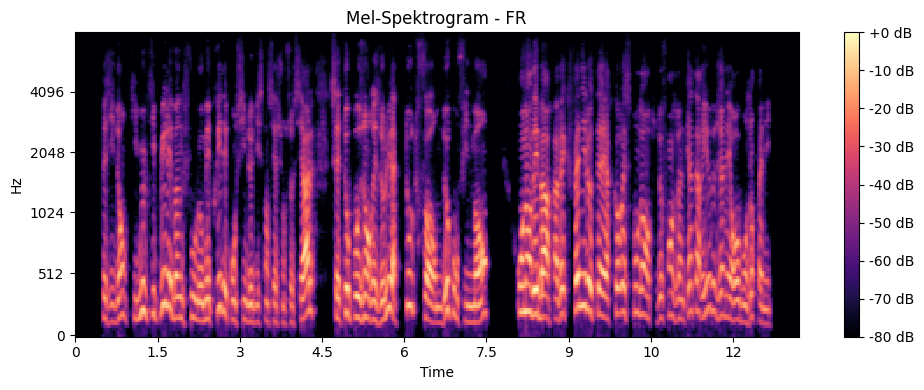

(128, 451)


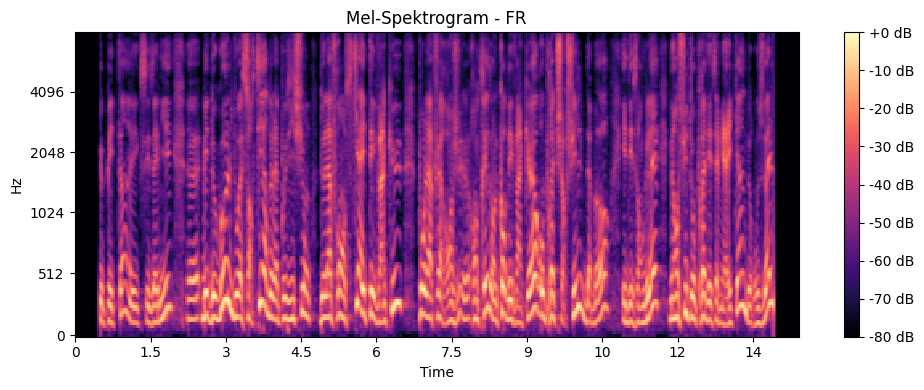

TR
(128, 454)


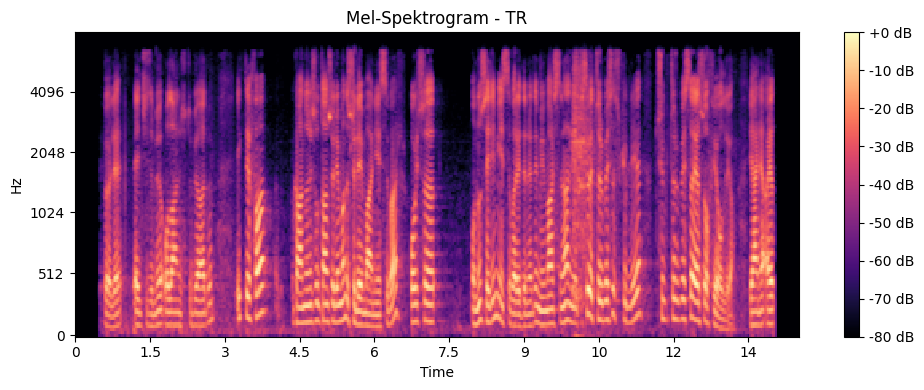

(128, 457)


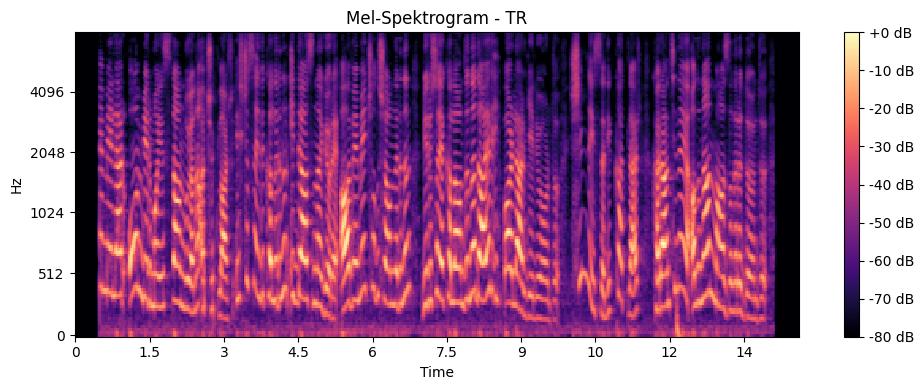

(128, 463)


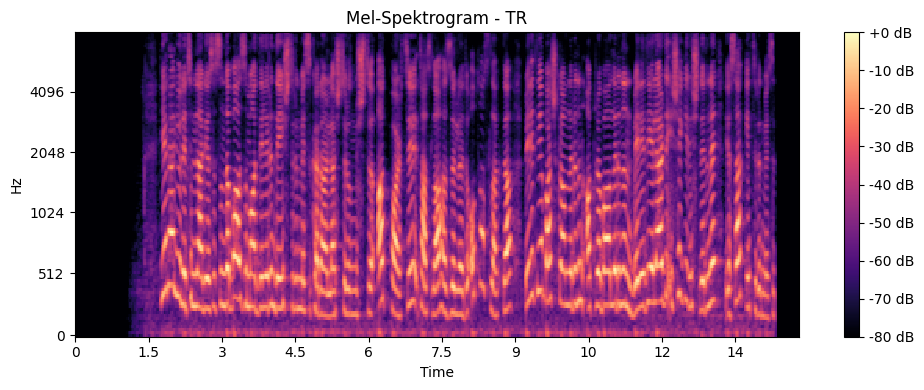

Minimum Length (seconds): 3.4
Maximum Length (seconds): 14.9
Total files shorter than 13 seconds: 572
Total files: 10022


In [7]:
min_len = np.inf
max_len = 0
short_files = 0
total_files = 0
for folder_name in os.listdir(DATA_DIR):
    print(folder_name)
    folder_path = os.path.join(DATA_DIR, folder_name)
    i = 0
    for filename in os.listdir(folder_path):
    
        if filename.endswith("txt"):
            continue
        
        total_files += 1

        path = os.path.join(folder_path, filename)
        y, sr = librosa.load(path, sr=None)

        if len(y) < min_len:
            min_len = len(y)
        
        if len(y) > max_len:
            max_len = len(y)

        if len(y) / sr < 13:
            short_files += 1

        if i < 3:
            spec_show(y,sr,folder_name)
        
        i+=1

print("Minimum Length (seconds):", min_len / 16000)
print("Maximum Length (seconds):", max_len / 16000)
print("Total files shorter than 13 seconds:", short_files)
print("Total files:", total_files)
        

**Not all audio files are the same length. In order to feed them to the CNN model, the spectrograms need to be of equal shape. We can ignore the very short sounds and apply padding to bring the sizes of the slightly short ones to the target size. Also, there are completely silent columns at the beginning and end of the sample spectrograms, these will need to be addressed as well.**

# Read Data and Choose Samples Longer than 13 Seconds

In [8]:
x_list = []
y_list = []


label = -1
for folder_name in os.listdir(DATA_DIR):
    label += 1
    print(folder_name)
    folder_path = os.path.join(DATA_DIR, folder_name)
    for filename in os.listdir(folder_path):

        if filename.endswith("txt"):
            continue
        
        path = os.path.join(folder_path, filename)
        y, sr = librosa.load(path, sr=None)

        seconds = len(y) / sr
        if seconds < 13:
            continue
        
        x_list.append(y)

        y_list.append(label) 

print(len(x_list) == len(y_list))

AR
ES
FR
TR
True


## Trim the silent parts that appear at the beginning and end of the audios

In [9]:
def trim_silence(waveform, threshold=1e-4):
    start_index = np.argmax(np.abs(waveform) > threshold)
    end_index = len(waveform) - np.argmax(np.abs(waveform[::-1]) > threshold) - 1
    
    trimmed_waveform = waveform[start_index:end_index+1]
    
    return trimmed_waveform

In [10]:
trimmed_max_len = 0
X_wave = x_list.copy()
for i in range(len(x_list)):
    signal = X_wave[i]
    X_wave[i] = trim_silence(signal)

    if len(signal) == max_len:
        trimmed_max_len = len(X_wave[i])

print("Maximum Audio Length:", trimmed_max_len)

Maximum Audio Length: 222400


## Determine the maximum width of spectrograms

In [11]:
SR = 16000
max_width = 0
for x in X_wave:
    signal = np.array(x)
    if len(signal) == trimmed_max_len:
        mel_spectrogram = librosa.feature.melspectrogram(y=signal, sr=SR, hop_length=HOP_LENGTH, n_fft=NFFT)
        width = mel_spectrogram.shape[1]
        max_width = width

print("Maximum Spectrogram Width:", max_width)

Maximum Spectrogram Width: 435


In [12]:
def audio_to_spec(y, sr):
    mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr, hop_length=512, n_fft=NFFT)
    
    db_spec = librosa.power_to_db(mel_spectrogram, ref=np.max)
    db_spec = librosa.util.fix_length(db_spec, size=max_width, axis=1, constant_values=-80)
    
    return db_spec

In [13]:
X_spec_list = []

for signal in X_wave:
    spec = audio_to_spec(signal, SR)
    X_spec_list.append(spec)

X = np.array(X_spec_list)
Y = np.array(y_list)

In [14]:
X_train, X_temp, Y_train, Y_temp = train_test_split(X, Y, train_size=0.6, stratify=Y)
X_val, X_test, Y_val, Y_test = train_test_split(X_temp, Y_temp, test_size=0.5, stratify=Y_temp)

X_train = torch.from_numpy(X_train).unsqueeze(1)
X_val = torch.from_numpy(X_val).unsqueeze(1)
X_test = torch.from_numpy(X_test).unsqueeze(1)

Y_train = torch.from_numpy(Y_train)
Y_val = torch.from_numpy(Y_val)
Y_test = torch.from_numpy(Y_test)

In [15]:
print(np.unique(Y_train, return_counts=True))
print(np.unique(Y_val, return_counts=True))
print(np.unique(Y_test, return_counts=True))

(array([0, 1, 2, 3]), array([1425, 1407, 1420, 1418]))
(array([0, 1, 2, 3]), array([475, 468, 474, 473]))
(array([0, 1, 2, 3]), array([475, 469, 473, 473]))


In [16]:
# y_train = F.one_hot(Y_train_labels, num_classes=4)
# y_val = F.one_hot(Y_val_labels, num_classes=4)
# y_test = F.one_hot(Y_test_labels, num_classes=4)
# y_train[:5]

In [17]:
spec_shape = X_train.shape
spec_shape

torch.Size([5670, 1, 128, 435])

# CNN

In [20]:
print(torch.cuda.device_count())
torch.cuda.get_device_name()

1


'NVIDIA GeForce RTX 3050 Laptop GPU'

In [21]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [22]:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3)
        self.bn1 = nn.BatchNorm2d(16)
        self.pool1 = nn.MaxPool2d(2, padding=1)
        self.drop1 = nn.Dropout2d(0.5)

        self.conv2 = nn.Conv2d(16, 32, kernel_size=3)
        self.pool2 = nn.MaxPool2d(2, padding=1)
        self.drop2 = nn.Dropout2d(0.5)

        self.conv3 = nn.Conv2d(32, 64, kernel_size=3)
        self.pool3 = nn.MaxPool2d(2, padding=1)
        self.drop3 = nn.Dropout2d(0.5)

        self.conv4 = nn.Conv2d(64, 128, kernel_size=3)
        self.pool4 = nn.MaxPool2d(2, padding=1)
        self.drop4 = nn.Dropout2d(0.5)

        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(27648, 128) 
        self.drop5 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, 4)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.leaky_relu(x)
        x = self.pool1(x)
        x = self.drop1(x)

        x = self.conv2(x)
        x = F.leaky_relu(x)
        x = self.pool2(x)
        x = self.drop2(x)

        x = self.conv3(x)
        x = F.leaky_relu(x)
        x = self.pool3(x)
        x = self.drop3(x)

        x = self.conv4(x)
        x = F.leaky_relu(x)
        x = self.pool4(x)
        x = self.drop4(x)

        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = self.drop5(x)
        x = self.fc2(x)

        return F.softmax(x, dim=1)


## Train the model

In [23]:
model = CNNModel()
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

batch_size = 32
train_dataset = TensorDataset(X_train, Y_train)
val_dataset = TensorDataset(X_val, Y_val)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

train_losses = []
val_losses = []

# Training
epochs = 200
for epoch in range(epochs):
    model.train()
    correct_train = 0
    total_train = 0
    train_loss = 0.0
    for x_batch, y_batch in train_loader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(x_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        
        _, predicted = torch.max(outputs, 1)
        total_train += y_batch.size(0)
        correct_train += (predicted == y_batch).sum().item()

    train_loss_epoch = train_loss / len(train_loader)
    train_losses.append(train_loss_epoch)
    train_accuracy = 100 * correct_train / total_train

    # Validation
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for x_val, y_val in val_loader:
            x_val, y_val = x_val.to(device), y_val.to(device)
            val_outputs = model(x_val)
            loss = criterion(val_outputs, y_val)
            val_loss += loss.item()

            _, predicted = torch.max(val_outputs, 1)
            total_val += y_val.size(0)
            correct_val += (predicted == y_val).sum().item()
        
        val_loss_epoch = val_loss / len(val_loader)
        val_losses.append(val_loss_epoch)
        val_accuracy = 100 * correct_val / total_val

    print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {train_loss_epoch:.4f}, "
          f"Train Accuracy: {train_accuracy:.2f}%, "
          f"Validation Loss: {val_loss_epoch:.4f}, "
          f"Validation Accuracy: {val_accuracy:.2f}%")

Epoch 1/200, Train Loss: 1.3915, Train Accuracy: 25.40%, Validation Loss: 1.3839, Validation Accuracy: 30.74%
Epoch 2/200, Train Loss: 1.3832, Train Accuracy: 27.62%, Validation Loss: 1.3777, Validation Accuracy: 26.46%
Epoch 3/200, Train Loss: 1.3725, Train Accuracy: 30.14%, Validation Loss: 1.3490, Validation Accuracy: 31.48%
Epoch 4/200, Train Loss: 1.3482, Train Accuracy: 34.87%, Validation Loss: 1.3074, Validation Accuracy: 40.32%
Epoch 5/200, Train Loss: 1.3349, Train Accuracy: 36.16%, Validation Loss: 1.3018, Validation Accuracy: 38.84%
Epoch 6/200, Train Loss: 1.3163, Train Accuracy: 38.68%, Validation Loss: 1.2745, Validation Accuracy: 44.71%
Epoch 7/200, Train Loss: 1.3030, Train Accuracy: 40.49%, Validation Loss: 1.2797, Validation Accuracy: 43.92%
Epoch 8/200, Train Loss: 1.2992, Train Accuracy: 41.08%, Validation Loss: 1.2643, Validation Accuracy: 44.44%
Epoch 9/200, Train Loss: 1.2894, Train Accuracy: 42.20%, Validation Loss: 1.2536, Validation Accuracy: 44.55%
Epoch 10/2

## Test the model

In [24]:
test_dataset = TensorDataset(X_test, Y_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

correct = 0
total = 0

# Test
with torch.no_grad(): 
    for x_batch, y_batch in test_loader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        outputs = model(x_batch)
        
        # Tahmin edilen sınıf
        _, predicted = torch.max(outputs, 1)  # en yüksek değere sahip sınıfı al
        
        # Toplam doğru tahmin ve toplam örnek sayısını güncelle
        total += y_batch.size(0)
        correct += (predicted == y_batch).sum().item()

# Doğruluğu hesapla
accuracy = 100 * correct / total
print(f'Test Accuracy: {accuracy:.2f}%')

Test Accuracy: 85.34%


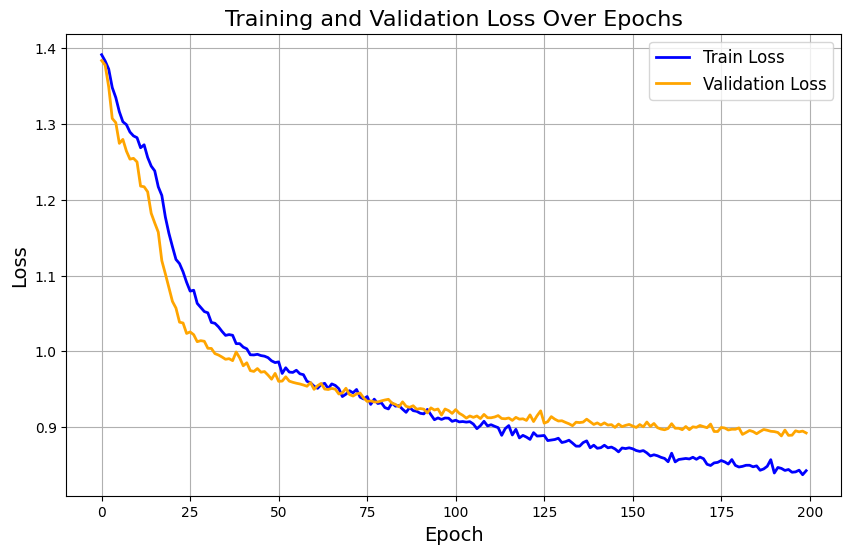

In [25]:
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label="Train Loss", color="blue", linewidth=2)
plt.plot(val_losses, label="Validation Loss", color="orange", linewidth=2)
plt.title("Training and Validation Loss Over Epochs", fontsize=16)
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("Loss", fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()

**Looks like overfitting occurs after epoch 100 (approximately)**